In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [18]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import calendar

# Add the parent directory to the Python path
from pathlib import Path

import numpy as np
import pandas as pd
import requests

from src.config import RAW_DATA_DIR
import zipfile

def fill_missing_rides_full_range(df, hour_col, location_col, rides_col):
    """
    Fills in missing rides for all hours in the range and all unique locations.

    Parameters:
    - df: DataFrame with columns [hour_col, location_col, rides_col]
    - hour_col: Name of the column containing hourly timestamps
    - location_col: Name of the column containing location IDs
    - rides_col: Name of the column containing ride counts

    Returns:
    - DataFrame with missing hours and locations filled in with 0 rides
    """
    # Ensure the hour column is in datetime format
    df[hour_col] = pd.to_datetime(df[hour_col])

    # Get the full range of hours (from min to max) with hourly frequency
    full_hours = pd.date_range(
        start=df[hour_col].min(),
        end=df[hour_col].max(),
        freq="h"
    )

    # Get all unique location IDs
    all_locations = df[location_col].unique()

    # Create a DataFrame with all combinations of hours and locations
    full_combinations = pd.DataFrame(
        [(hour, location) for hour in full_hours for location in all_locations],
        columns=[hour_col, location_col]
    )

    # Merge the original DataFrame with the full combinations DataFrame
    merged_df = pd.merge(full_combinations, df, on=[hour_col, location_col], how='left')

    # Fill missing rides with 0
    merged_df[rides_col] = merged_df[rides_col].fillna(0).astype(int)

    return merged_df

def fetch_raw_trip_data(year: int, month: int) -> Path:
    URL = f"https://s3.amazonaws.com/tripdata/JC-{year}{month:02}-citibike-tripdata.csv.zip"     
    response = requests.get(URL)

    if response.status_code == 200:
        zip_path = RAW_DATA_DIR / f"rides_{year}_{month:02}.zip"
        open(zip_path, "wb").write(response.content)
        # Extract the zip file
        extracted_dir = RAW_DATA_DIR / "extracted_raw"
        extracted_dir.mkdir(exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
        
        # Find the CSV file in the extracted directory
        csv_files = list(extracted_dir.glob("*.csv"))
        if not csv_files:
            raise Exception(f"No CSV file found in the extracted zip: {zip_path}")
        
        return csv_files[0]
    else:
        raise Exception(f"{URL} is not available")
    

def load_and_process_citi_data(years: list) -> pd.DataFrame:
    """
    Load and process CitiBike data for a specified year and list of months.

    Args:
        years (list): List of years to load data for.

    Returns:
        pd.DataFrame: Combined and processed ride data for the specified years.

    Raises:
        Exception: If no data could be loaded for the specified years.
    """

    months = list(range(1, 13))
    # List to store DataFrames for each month
    monthly_rides = []

    for year in years:
        for month in months:
            # Construct the file path
            file_path = RAW_DATA_DIR / f"JC-{year}{month:02}-citibike-tripdata.csv"

            # Load the data
            print(f"Loading data for {year}-{month:02}.")
            try:
                rides = pd.read_csv(file_path)
            # Append the processed DataFrame to the list
                monthly_rides.append(rides)
            except FileNotFoundError:
                continue

        # Combine all monthly data
        if not monthly_rides:
            raise Exception(
                f"No data could be loaded for the year {year} and specified months: {months}"
            )

        print("Combining all monthly data...")
        combined_rides = pd.concat(monthly_rides, ignore_index=True)
        print("Data loading and processing complete!")

        columns_to_drop = ['ride_id', 'end_station_name', 'rideable_type', 'ended_at', 'end_station_id','start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']  # Specify the columns to drop
        processed_rides = combined_rides.drop(columns=columns_to_drop)

        processed_rides.rename(columns={"started_at": "pickup_datetime", "start_station_name": "station_name", "start_station_id": "station_id"}, inplace=True)        

    return combined_rides, processed_rides

def transform_data_into_ts_data(rides: pd.DataFrame) -> pd.DataFrame:
    """
    Transform raw ride data into time series format.

    Args:
        rides: DataFrame with pickup_datetime and location columns

    Returns:
        pd.DataFrame: Time series data with filled gaps
    """
    # Floor datetime to hour efficiently
    rides["pickup_hour"] = pd.to_datetime(rides["pickup_hour"], format="%Y-%m-%d %H:%M:%S")
    rides["pickup_hour"] = rides["pickup_hour"].dt.floor("h")

    # Aggregate and fill gaps
    agg_rides = (
        rides.groupby(["pickup_hour", "station_id"])
        .size()
        .reset_index(name="rides")
    )

    # Filter data based on the list of station_id values
    station_ids = ["HB101", "HB202", "JC103"]  # Example list of station IDs
    filtered_data = agg_rides[agg_rides["station_id"].isin(station_ids)]
    return filtered_data 

In [3]:
def transform_ts_data_info_features_and_target(
    df, feature_col="rides", window_size=12, step_size=1
):
    """
    Transforms time series data for all unique location IDs into a tabular format.
    The first `window_size` rows are used as features, and the next row is the target.
    The process slides down by `step_size` rows at a time to create the next set of features and target.
    Feature columns are named based on their hour offsets relative to the target.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing time series data with 'pickup_hour' column.
        feature_col (str): The column name containing the values to use as features and target (default is "rides").
        window_size (int): The number of rows to use as features (default is 12).
        step_size (int): The number of rows to slide the window by (default is 1).

    Returns:
        tuple: (features DataFrame with pickup_hour, targets Series, complete DataFrame)
    """
    # Get all unique location IDs
    location_ids = df["station_id"].unique()
    # List to store transformed data for each location
    transformed_data = []

    # Loop through each location ID and transform the data
    for location_id in location_ids:
        try:
            # Filter the data for the given location ID
            location_data = df[df["station_id"] == location_id].reset_index(
                drop=True
            )

            # Extract the feature column and pickup_hour as NumPy arrays
            values = location_data[feature_col].values
            times = location_data["pickup_hour"].values

            # Ensure there are enough rows to create at least one window
            if len(values) <= window_size:
                raise ValueError("Not enough data to create even one window.")

            # Create the tabular data using a sliding window approach
            rows = []
            for i in range(0, len(values) - window_size, step_size):
                # The first `window_size` values are features, and the next value is the target
                features = values[i : i + window_size]
                target = values[i + window_size]
                # Get the corresponding target timestamp
                target_time = times[i + window_size]
                # Combine features, target, location_id, and timestamp
                row = np.append(features, [target, location_id, target_time])
                rows.append(row)

            # Convert the list of rows into a DataFrame
            feature_columns = [
                f"{feature_col}_t-{window_size - i}" for i in range(window_size)
            ]
            all_columns = feature_columns + [
                "target",
                "station_id",
                "pickup_hour",
            ]
            transformed_df = pd.DataFrame(rows, columns=all_columns)

            # Append the transformed data to the list
            transformed_data.append(transformed_df)

        except ValueError as e:
            print(f"Skipping location_id {location_id}: {str(e)}")

    # Combine all transformed data into a single DataFrame
    if not transformed_data:
        raise ValueError(
            "No data could be transformed. Check if input DataFrame is empty or window size is too large."
        )

    final_df = pd.concat(transformed_data, ignore_index=True)

    # Extract features (including pickup_hour), targets, and keep the complete DataFrame
    features = final_df[feature_columns + ["pickup_hour", "station_id"]]
    targets = final_df["target"]

    return features, targets

In [ ]:
hour_col = "pickup_hour"
location_col = "station_id"
rides_col = "rides"
years = [2021, 2023, 2022]
raw_df, df = load_and_process_citi_data(years)

#ts_data = transform_data_into_ts_data(df)

Loading data for 2021-01.
Loading data for 2021-02.
Loading data for 2021-03.
Loading data for 2021-04.
Loading data for 2021-05.
Loading data for 2021-06.
Loading data for 2021-07.
Loading data for 2021-08.
Loading data for 2021-09.
Loading data for 2021-10.
Loading data for 2021-11.
Loading data for 2021-12.
Combining all monthly data...
Data loading and processing complete!
Loading data for 2023-01.
Loading data for 2023-02.
Loading data for 2023-03.
Loading data for 2023-04.
Loading data for 2023-05.
Loading data for 2023-06.
Loading data for 2023-07.
Loading data for 2023-08.
Loading data for 2023-09.
Loading data for 2023-10.
Loading data for 2023-11.
Loading data for 2023-12.
Combining all monthly data...
Data loading and processing complete!
Loading data for 2022-01.
Loading data for 2022-02.
Loading data for 2022-03.
Loading data for 2022-04.
Loading data for 2022-05.
Loading data for 2022-06.
Loading data for 2022-07.
Loading data for 2022-08.
Loading data for 2022-09.
Loadin

In [ ]:
from datetime import datetime
from typing import List, Optional, Tuple, Union

# Pre-Req functions
def fill_missing_rides_full_range(df, hour_col, location_col, rides_col):
    """
    Fills in missing rides for all hours in the range and all unique locations.

    Parameters:
    - df: DataFrame with columns [hour_col, location_col, rides_col]
    - hour_col: Name of the column containing hourly timestamps
    - location_col: Name of the column containing location IDs
    - rides_col: Name of the column containing ride counts

    Returns:
    - DataFrame with missing hours and locations filled in with 0 rides
    """
    # Ensure the hour column is in datetime format
    df[hour_col] = pd.to_datetime(df[hour_col])

    # Get the full range of hours (from min to max) with hourly frequency
    full_hours = pd.date_range(
        start=df[hour_col].min(),
        end=df[hour_col].max(),
        freq="h"
    )

    # Get all unique location IDs
    all_locations = df[location_col].unique()

    # Create a DataFrame with all combinations of hours and locations
    full_combinations = pd.DataFrame(
        [(hour, location) for hour in full_hours for location in all_locations],
        columns=[hour_col, location_col]
    )

    # Merge the original DataFrame with the full combinations DataFrame
    merged_df = pd.merge(full_combinations, df, on=[hour_col, location_col], how='left')

    # Fill missing rides with 0
    merged_df[rides_col] = merged_df[rides_col].fillna(0).astype(int)

    return merged_df
# -----------------------------Data Cleaning Start-----------------------------

def load_and_process_citi_data(years: list,  months: Optional[List[int]] = None) -> pd.DataFrame:
    if months is None:
        months = list(range(1, 13))
    # List to store DataFrames for each month
    monthly_rides = []

    for year in years:
        for month in months:
            # Construct the file path
            file_path = RAW_DATA_DIR / f"JC-{year}{month:02}-citibike-tripdata.csv"

            # Load the data
            print(f"Loading data for {year}-{month:02}.")
            try:
                rides = pd.read_csv(file_path)
            # Append the processed DataFrame to the list
                monthly_rides.append(rides)
            except FileNotFoundError:
                continue

        # Combine all monthly data
        if not monthly_rides:
            raise Exception(
                f"No data could be loaded for the year {year} and specified months: {months}"
            )

        print("Combining all monthly data...")
        combined_rides = pd.concat(monthly_rides, ignore_index=True)
        print("Data loading and processing complete!")

        columns_to_drop = ['ride_id', 'end_station_name', 'rideable_type', 'ended_at', 'end_station_id','start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']  # Specify the columns to drop
        processed_rides = combined_rides.drop(columns=columns_to_drop)

        processed_rides.rename(columns={"started_at": "pickup_hour", "start_station_name": "station_name", "start_station_id": "station_id"}, inplace=True)        

    return combined_rides, processed_rides

In [ ]:

def return_data_for_model(df):
    # Filter data for the desired data locations
    station_ids = ['HB101', 'HB105', 'HB305']  # Replace with your list of station_id values
    df = df[df["station_id"].isin(station_ids)]

    # convert the datatype for pickup
    df["pickup_hour"] = pd.to_datetime(df["pickup_hour"])
    df["pickup_hour"] = df["pickup_hour"].dt.floor('h') # floor is to the nearest hour

    # Group data and make it more better looking
    df = df.groupby(["pickup_hour", "station_id"]).size().reset_index()
    df.rename(columns={0: "rides"}, inplace=True)

    hour_col = "pickup_hour"
    location_col = "station_id"
    rides_col = "rides"
    interval = "6H"
    df = fill_missing_rides_full_range(df, hour_col, location_col, rides_col).sort_values(["station_id", "pickup_hour"]).reset_index(drop=True)

    particular_date_6h = datetime(2021, 7, 17)
    df = df[df["pickup_hour"] >= particular_date_6h]     

    # Set the hour column as the index
    df = df.set_index(hour_col)
#
    ## Resample and aggregate rides
    df = df.groupby("station_id").resample(interval)[rides_col].sum().reset_index()

    return df

In [124]:
years = [2021, 2022, 2023]
raw_df, df = load_and_process_citi_data(years)

Loading data for 2021-01.
Loading data for 2021-02.
Loading data for 2021-03.
Loading data for 2021-04.
Loading data for 2021-05.
Loading data for 2021-06.
Loading data for 2021-07.
Loading data for 2021-08.
Loading data for 2021-09.
Loading data for 2021-10.
Loading data for 2021-11.
Loading data for 2021-12.
Combining all monthly data...
Data loading and processing complete!
Loading data for 2022-01.
Loading data for 2022-02.
Loading data for 2022-03.
Loading data for 2022-04.
Loading data for 2022-05.
Loading data for 2022-06.
Loading data for 2022-07.
Loading data for 2022-08.
Loading data for 2022-09.
Loading data for 2022-10.
Loading data for 2022-11.
Loading data for 2022-12.
Combining all monthly data...
Data loading and processing complete!
Loading data for 2023-01.
Loading data for 2023-02.
Loading data for 2023-03.
Loading data for 2023-04.
Loading data for 2023-05.
Loading data for 2023-06.
Loading data for 2023-07.
Loading data for 2023-08.
Loading data for 2023-09.
Loadin

In [117]:
df.head()

,pickup_hour,station_name,station_id
0,2021-07-15 19:27:25,Journal Square,JC103
1,2021-07-22 06:41:54,Journal Square,JC103
2,2021-07-19 06:36:13,Brunswick & 6th,JC081
3,2021-07-08 06:33:45,Brunswick & 6th,JC081
4,2021-07-21 07:33:49,14 St Ferry - 14 St & Shipyard Ln,HB202


In [125]:
df = return_data_for_model(df)

In [127]:
df.head()

,station_id,pickup_hour,rides
0,3132.09,2021-07-17 00:00:00,0
1,3132.09,2021-07-17 06:00:00,0
2,3132.09,2021-07-17 12:00:00,0
3,3132.09,2021-07-17 18:00:00,0
4,3132.09,2021-07-18 00:00:00,0


In [128]:
unique_values = df["station_id"].unique()
unique_values

array(['3132.09', '3263.01', '3710.07', '3814.01', '3914.02', '4010.15',
       '4025.02', '4060.09', '4089.01', '4098.06', '4128.08', '4143.04',
       '4243.01', '4249.10', '4281.08', '4317.05', '4319.07', '4366.01',
       '4368.05', '4380.08', '4395.07', '4404.10', '4437.09', '4446.03',
       '4474.01', '4483.10', '4507.07', '4510.04', '4519.02', '4531.05',
       '4550.05', '4553.04', '4614.04', '4617.01', '4637.06', '4651.02',
       '4663.06', '4665.02', '4683.02', '4756.04', '4784.02', '4812.04',
       '4816.05', '4824.03', '4850.04', '4906.07', '4936.21', '4987.06',
       '4993.02', '5024.10', '5033.01', '5045.05', '5065.04', '5065.10',
       '5065.12', '5065.14', '5073.07', '5114.06', '5117.05', '5128.04',
       '5134.09', '5164.05', '5178.06', '5184.08', '5195.06', '5198.04',
       '5207.01', '5216.06', '5235.05', '5247.10', '5267.08', '5270.08',
       '5276.04', '5279.03', '5288.09', '5294.04', '5297.02', '5303.06',
       '5303.08', '5329.08', '5340.01', '5348.02', 

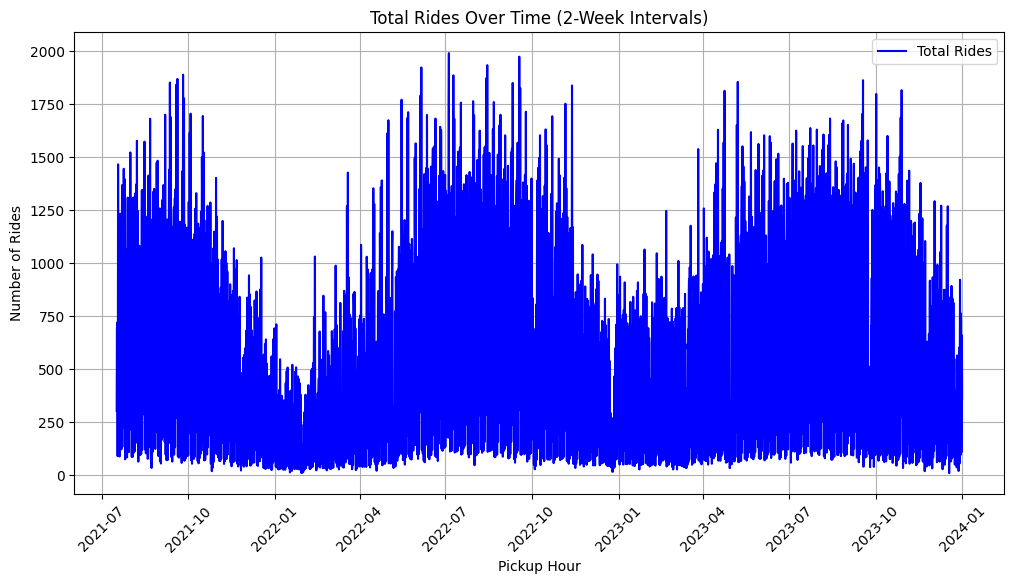

In [129]:
import matplotlib.pyplot as plt

# Convert 'pickup_hour' to datetime for proper plotting
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

# Group data by 'pickup_hour' and sum rides for each hour
agg_data = df.groupby("pickup_hour")["rides"].sum()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(agg_data.index, agg_data.values, label="Total Rides", color="blue")

# Add labels and title
plt.xlabel("Pickup Hour")
plt.ylabel("Number of Rides")
plt.title("Total Rides Over Time (2-Week Intervals)")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [131]:
station_ids = ['HB101', 'HB105', 'HB305']  # Replace with your list of station_id values
df_2 = df[df["station_id"].isin(station_ids)]

In [132]:
df_2

,station_id,pickup_hour,rides
955472,HB101,2021-07-17 00:00:00,15
955473,HB101,2021-07-17 06:00:00,38
955474,HB101,2021-07-17 12:00:00,43
955475,HB101,2021-07-17 18:00:00,43
955476,HB101,2021-07-18 00:00:00,10
...,...,...,...
998571,HB305,2023-12-30 18:00:00,4
998572,HB305,2023-12-31 00:00:00,2
998573,HB305,2023-12-31 06:00:00,6
998574,HB305,2023-12-31 12:00:00,6


In [136]:
def transform_ts_data_info_features_and_target(
    df, feature_col="rides", window_size=12, step_size=1
):
    # Get all unique location IDs
    location_ids = df["station_id"].unique()
    # List to store transformed data for each location
    transformed_data = []

    # Loop through each location ID and transform the data
    for location_id in location_ids:
        try:
            # Filter the data for the given location ID
            location_data = df[df["station_id"] == location_id].reset_index(
                drop=True
            )

            # Extract the feature column and pickup_hour as NumPy arrays
            values = location_data[feature_col].values
            times = location_data["pickup_hour"].values

            # Ensure there are enough rows to create at least one window
            if len(values) <= window_size:
                raise ValueError("Not enough data to create even one window.")

            # Create the tabular data using a sliding window approach
            rows = []
            for i in range(0, len(values) - window_size, step_size):
                # The first `window_size` values are features, and the next value is the target
                features = values[i : i + window_size]
                target = values[i + window_size]
                # Get the corresponding target timestamp
                target_time = times[i + window_size]
                # Combine features, target, location_id, and timestamp
                row = np.append(features, [target, location_id, target_time])
                rows.append(row)

            # Convert the list of rows into a DataFrame
            feature_columns = [
                f"{feature_col}_t-{window_size - i}" for i in range(window_size)
            ]
            all_columns = feature_columns + [
                "target",
                "station_id",
                "pickup_hour",
            ]
            transformed_df = pd.DataFrame(rows, columns=all_columns)

            # Append the transformed data to the list
            transformed_data.append(transformed_df)

        except ValueError as e:
            print(f"Skipping location_id {location_id}: {str(e)}")

    # Combine all transformed data into a single DataFrame
    if not transformed_data:
        raise ValueError(
            "No data could be transformed. Check if input DataFrame is empty or window size is too large."
        )

    final_df = pd.concat(transformed_data, ignore_index=True)

    # Extract features (including pickup_hour), targets, and keep the complete DataFrame
    features = final_df[feature_columns + ["pickup_hour", "station_id"]]
    targets = final_df["target"]

    return features, targets

In [137]:
features, targets = transform_ts_data_info_features_and_target(df_2, window_size=672, step_size=1)

In [138]:
df = pd.concat([features, targets], axis=1)

In [139]:
df

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,station_id,target
0,15,38,43,43,10,12,73,40,2,15,...,2,21,16,6,6,22,15,2022-01-01 00:00:00,HB101,8
1,38,43,43,10,12,73,40,2,15,50,...,21,16,6,6,22,15,8,2022-01-01 06:00:00,HB101,4
2,43,43,10,12,73,40,2,15,50,40,...,16,6,6,22,15,8,4,2022-01-01 12:00:00,HB101,4
3,43,10,12,73,40,2,15,50,40,2,...,6,6,22,15,8,4,4,2022-01-01 18:00:00,HB101,3
4,10,12,73,40,2,15,50,40,2,34,...,6,22,15,8,4,4,3,2022-01-02 00:00:00,HB101,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,5,1,5,13,9,3,13,19,9,3,...,0,10,10,5,3,4,12,2023-12-30 18:00:00,HB305,4
8756,1,5,13,9,3,13,19,9,3,16,...,10,10,5,3,4,12,4,2023-12-31 00:00:00,HB305,2
8757,5,13,9,3,13,19,9,3,16,21,...,10,5,3,4,12,4,2,2023-12-31 06:00:00,HB305,6
8758,13,9,3,13,19,9,3,16,21,20,...,5,3,4,12,4,2,6,2023-12-31 12:00:00,HB305,6


In [143]:
# Ensure the 'pickup_hour' column is in datetime format
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

# Split the data into training (2022) and testing (2023)
train_data = df[df['pickup_hour'].dt.year == 2022]
test_data = df[df['pickup_hour'].dt.year == 2023]

# Separate features (X) and target (Y)
X_train = train_data.drop(columns=['target','pickup_hour','station_id'])
y_train = train_data['target']

X_test = test_data.drop(columns=['target','pickup_hour','station_id'])
y_test = test_data['target']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4380, 672)
(4380,)
(4380, 672)
(4380,)


In [144]:
X_train

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-10,rides_t-9,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1
0,15,38,43,43,10,12,73,40,2,15,...,14,23,2,2,21,16,6,6,22,15
1,38,43,43,10,12,73,40,2,15,50,...,23,2,2,21,16,6,6,22,15,8
2,43,43,10,12,73,40,2,15,50,40,...,2,2,21,16,6,6,22,15,8,4
3,43,10,12,73,40,2,15,50,40,2,...,2,21,16,6,6,22,15,8,4,4
4,10,12,73,40,2,15,50,40,2,34,...,21,16,6,6,22,15,8,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,9,1,15,21,11,2,16,17,8,0,...,3,10,4,0,5,13,7,0,5,14
7296,1,15,21,11,2,16,17,8,0,7,...,10,4,0,5,13,7,0,5,14,6
7297,15,21,11,2,16,17,8,0,7,6,...,4,0,5,13,7,0,5,14,6,1
7298,21,11,2,16,17,8,0,7,6,6,...,0,5,13,7,0,5,14,6,1,8


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Define and train LightGBM model
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)

# 3. Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"LightGBM MAE: {mae:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48824
[LightGBM] [Info] Number of data points in the train set: 4380, number of used features: 672
[LightGBM] [Info] Start training from score 14.637215
LightGBM MAE: 4.61


In [152]:
MODELS_DIR = os.getenv("MODELS_DIR")

In [161]:
import joblib

joblib.dump(model,"/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/Pedal-Predict/models/lgb_model.pkl")

['/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/Pedal-Predict/models/lgb_model.pkl']

In [171]:
import src.config as config
api_key = os.getenv('HOPSWORKS_API_KEY')  
project_name = os.getenv('HOPSWORKS_PROJECT_NAME')  
grp_name = os.getenv('FEATURE_GROUP_NAME')
grp_ver = os.getenv('FEATURE_GROUP_VERSION')

In [175]:
import hopsworks

project = hopsworks.login(
    project=project_name, api_key_value=api_key
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name = grp_name,
    version = grp_ver
)

2025-05-10 03:18:33,706 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-10 03:18:33,711 INFO: Initializing external client
2025-05-10 03:18:33,711 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 03:18:34,414 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1225934


In [162]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

/opt/anaconda3/envs/citi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [176]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="bike_demand_predictor_next_hour",
    metrics={"test_mae": mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/Pedal-Predict/models/lgb_model.pkl')

Uploading /Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/Pedal-Predict/models/lgb_model.pkl: 100.000%|██████████| 303016/303016 elapsed<00:01 remaining<00:00
Uploading /Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/Pedal-Predict/input_example.json: 100.000%|██████████| 2511/2511 elapsed<00:01 remaining<00:00
Uploading /Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/Pedal-Predict/model_schema.json: 100.000%|██████████| 48609/48609 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1225934/models/bike_demand_predictor_next_hour/1


Model(name: 'bike_demand_predictor_next_hour', version: 1)

In [2]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

/opt/anaconda3/envs/citi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'config' is not defined

In [1]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: name 'feature_store' is not defined
Error retrieving feature view: name 'feature_store' is not defined
